In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob

# Weather Data Processing

In this notebook, daily weather variables are integrated with the retail footfall dataset. 

Gridded rainfall and temperature data from HadUK-Grid are matched to retail centre locations using centroid coordinates, while CEDA wind observations were cleaned, aggregated to daily daytime values, and spatially interpolated to retail centres across the UK. 

These weather measures were then joined to the retail dataset, producing a final panel of retail centres with daily footfall and corresponding meteorological conditions.

### 1.1. HadUK-Grid

#### 1.1.1. Loading in the data

First, our footfall/retail data generated in the previous notebook 

In [ ]:
retail_areas = gpd.read_file("retail_areas.gpkg", layer="retail_areas")

Weather will be assigned based on the centroid of each retail centre. 

Compute the centroids and prepare output cols for weather:

In [ ]:
# compute centroids
retail_areas['centroid'] = retail_areas.geometry.centroid

# prepare output columns
retail_areas['rainfall'] = np.nan
retail_areas['tasmax'] = np.nan
retail_areas['tasmin'] = np.nan

Now, load the rainfall data:

The HadUK data comes as a set of files for each month. We need to load in all the files and then patch them together to create a full-year series. 

In [ ]:
# get all .nc files in the folder
files = sorted(glob.glob("Data/rainfall/*.nc"))

# load and combine along the time dimension
rain_ds = xr.open_mfdataset(files, combine='by_coords')

# check the structure
print(rain_ds)

<xarray.Dataset> Size: 156MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    rainfall                      (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

We do the same for maximum temperature:

In [7]:
# get all .nc files in the folder
files = sorted(glob.glob("Data/maxtemp/*.nc"))

# load and combine along the time dimension
maxtemp_ds = xr.open_mfdataset(files, combine='by_coords')

# check the structure
print(maxtemp_ds)

<xarray.Dataset> Size: 156MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmax                        (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

And minumum temperature (even though we stick with max temp later on):

In [8]:
# get all .nc files in the folder
files = sorted(glob.glob("Data/mintemp/*.nc"))

# load and combine along the time dimension
mintemp_ds = xr.open_mfdataset(files, combine='by_coords')

# check the structure
print(mintemp_ds)

<xarray.Dataset> Size: 156MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmin                        (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

With the data all loaded and compiled for the entire year, we can merge the grids together:

In [9]:
rain_ds = rain_ds.drop_vars('time_bnds', errors='ignore')
maxtemp_ds = maxtemp_ds.drop_vars('time_bnds', errors='ignore')
mintemp_ds = mintemp_ds.drop_vars('time_bnds', errors='ignore')

merged_ds = xr.merge([rain_ds, maxtemp_ds, mintemp_ds])

This creates a 5x5km resolution surface for the entire UK of rain and temperature altogether. 

In [10]:
print(merged_ds)

<xarray.Dataset> Size: 462MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    rainfall                      (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

#### 1.1.2 Join HAD-UK grid to mobile data

At this point, we want to add the rain and temp obsverations to our retail footfall data. 

We do this based on both date and location. HadUK data comes in a daily resolution. Luckily, we've already aggregated our footfall data to a daily scale. 

First, we need to make sure the dates are in the correct data format: 

In [1]:
# convert NetCDF time to date only for matching
netcdf_dates = pd.to_datetime(merged_ds['time'].values).date
date_to_time_index = {date: idx for idx, date in enumerate(netcdf_dates)}

NameError: name 'pd' is not defined

We also need to make sure coordinate reference systems align:

In [12]:
from geopandas import GeoSeries

# convert retail areas date to datetime
retail_areas['date'] = pd.to_datetime(retail_areas['date'], errors='coerce')  
# matching retail format
retail_areas['date'] = retail_areas['date'].dt.date  # extract date
# ensure geometry is in WGS84
retail_areas = retail_areas.to_crs("EPSG:4326")
# reproject centroids to WGS84
retail_areas['centroid'] = GeoSeries(retail_areas['centroid'], crs="EPSG:27700").to_crs("EPSG:4326")
# extract lon/lat from reprojected centroids
retail_areas['centroid_x'] = retail_areas['centroid'].x  # longitude
retail_areas['centroid_y'] = retail_areas['centroid'].y  # latitude

In [13]:
# extract lat/lon and make grid
lat_grid = merged_ds['latitude'].values  # shape (290, 180)
lon_grid = merged_ds['longitude'].values  # shape (290, 180)

With the data prepared for the merge, we're now going to loop through each date of the retail footfall data and HadUK data, and assign weather variables based on the nearest grid cell to the retail area centroid:

Extract weather variables:

In [14]:
from tqdm import tqdm

# loop by date group
for date, group in tqdm(retail_areas.groupby('date'), desc="Processing by date"):
    if date not in date_to_time_index:
        continue

    t_idx = date_to_time_index[date]

    # extract weather data for that date
    rain_t = merged_ds['rainfall'].isel(time=t_idx).values
    tmax_t = merged_ds['tasmax'].isel(time=t_idx).values
    tmin_t = merged_ds['tasmin'].isel(time=t_idx).values

    for idx, row in group.iterrows():
        # get centroid coords
        lon_pt, lat_pt = row['centroid_x'], row['centroid_y']

        # find nearest grid cell
        dist_sq = (lon_grid - lon_pt) ** 2 + (lat_grid - lat_pt) ** 2
        i, j = np.unravel_index(dist_sq.argmin(), dist_sq.shape)

        if i >= rain_t.shape[0] or j >= rain_t.shape[1]:
            continue

        # assign values back to main df
        retail_areas.at[idx, 'rainfall'] = rain_t[i, j]
        retail_areas.at[idx, 'tasmax'] = tmax_t[i, j]
        retail_areas.at[idx, 'tasmin'] = tmin_t[i, j]

Processing by date:   0%|          | 0/366 [00:00<?, ?it/s]

Processing by date: 100%|██████████| 366/366 [01:04<00:00,  5.70it/s]


We can check the result to make sure it worked:

In [15]:
retail_areas['date'] = pd.to_datetime(retail_areas['date'])
target_date = pd.to_datetime('2024-09-02').date()  # date object
# filter retail_areas for the target_date and where rainfall is not NaN
filtered_rain = retail_areas[
    (retail_areas['date'].dt.date == target_date) & 
    (~retail_areas['rainfall'].isna())
]
display(filtered_rain)

,date,id,events,weekend,season,holiday,Local Footprint Name,Region,Base Score,Retail Footprint Score,...,groupID,groupName,coastal,geometry,centroid,rainfall,tasmax,tasmin,centroid_x,centroid_y
41,2024-09-02,17519.0,1173.0,False,Summer,False,Grays - West Thurrock,East of England,802.0,767.0,...,2.1,Primary shopping centres and premium destinations,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),1.189453,22.658203,17.374023,0.277208,51.484639
567,2024-09-02,21649.0,2048.0,False,Summer,False,Broadstairs - Westwood Cr,South East,738.0,707.0,...,2.2,Secondary retail parks and shopping centres,inland,"MULTIPOLYGON (((1.39419 51.36348, 1.39422 51.3...",POINT (1.39485 51.35918),0.428711,24.911133,17.608398,1.394852,51.359179
839,2024-09-02,26011.0,564.0,False,Summer,False,York - Monks Cross Shoppi,Yorkshire and The Humber,524.0,504.0,...,2.2,Secondary retail parks and shopping centres,inland,"MULTIPOLYGON (((-1.04342 53.98527, -1.04348 53...",POINT (-1.04712 53.98623),0.085938,20.848633,15.643555,-1.047118,53.986227
1289,2024-09-02,35864.0,64.0,False,Summer,False,Paisley - Phoenix Retail,Scotland,237.0,229.0,...,2.2,Secondary retail parks and shopping centres,inland,"MULTIPOLYGON (((-4.47732 55.84771, -4.47696 55...",POINT (-4.47239 55.84542),17.220703,15.705078,14.320312,-4.472393,55.845425
1576,2024-09-02,13522.0,399.0,False,Summer,False,Stockton-on-Tees - Portra,North East,386.0,371.0,...,2.2,Secondary retail parks and shopping centres,inland,"MULTIPOLYGON (((-1.28214 54.57728, -1.282 54.5...",POINT (-1.28312 54.57442),0.516602,20.616211,14.994141,-1.283122,54.574424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435766,2024-09-02,1972.0,274.0,False,Summer,False,Sutton - Carshalton Road,London,771.0,851.0,...,3.2,Sub-regional retail and leisure destinations,inland,"MULTIPOLYGON (((-0.18735 51.3626, -0.18735 51....",POINT (-0.18729 51.36258),2.102539,21.117188,17.612305,-0.187291,51.362577
436085,2024-09-02,15563.0,10.0,False,Summer,False,Plymouth - City Centre -,South West,1121.0,997.0,...,3.2,Sub-regional retail and leisure destinations,coastal,"MULTIPOLYGON (((-4.1334 50.37275, -4.13339 50....",POINT (-4.13336 50.37277),1.584961,19.199219,16.147461,-4.133363,50.372766
436756,2024-09-02,10461.0,45.0,False,Summer,False,Bristol - Montpelier - Ba,South West,180.0,190.0,...,1.1,Local urban convenience centres,inland,"MULTIPOLYGON (((-2.58954 51.46502, -2.58955 51...",POINT (-2.58953 51.46504),2.607422,21.267578,18.312500,-2.589534,51.465039
437069,2024-09-02,29424.0,21.0,False,Summer,False,Bury St Edmunds - Victori,East of England,705.0,633.0,...,3.2,Sub-regional retail and leisure destinations,inland,"MULTIPOLYGON (((0.70907 52.24696, 0.70905 52.2...",POINT (0.70905 52.24698),3.571289,22.602539,16.431641,0.709053,52.246976


Double check for duplicates:

In [17]:
# check for duplicate rows in retail_areas based on all columns
duplicate_rows = retail_areas.duplicated()
print(f"Number of completely duplicated rows: {duplicate_rows.sum()}")

# check for duplicate IDs per date (should be unique for each date/id)
duplicate_id_date = retail_areas.duplicated(subset=['id', 'date'])
print(f"Number of duplicated (id, date) pairs: {duplicate_id_date.sum()}")

# show some examples if any duplicates exist
if duplicate_id_date.any():
    display(retail_areas[duplicate_id_date].head())

Number of completely duplicated rows: 0
Number of duplicated (id, date) pairs: 0


### 1.3. CEDA sun hours data

At first I wanted to include sunshine data. This was not possible due to lack of data availability. 

As you'll see if you scroll down, very few stations have complete observations. Interpolating sunshine values for the entire country based on these stations would generate inaccurate results. 

So, sunshine was not included in the final models.

If you're bored already, you can skip this section.

#### 1.3.1 Loading in

In [18]:
# define the header based on provided column names
column_names = [
    "OB_END_TIME", "ID", "ID_TYPE", "OB_HOUR_COUNT", "VERSION_NUM",
    "MET_DOMAIN_NAME", "SRC_ID", "REC_ST_IND", "CS_24HR_SUN_DUR",
    "CONC_STATE_ID", "LYING_SNOW_FLAG", "SNOW_DEPTH", "FRSH_SNOW_AMT",
    "SNOW_DAY_ID", "HAIL_DAY_ID", "THUNDER_DAY_FLAG", "GALE_DAY_FLAG",
    "FRSH_MNT_SNWFALL_FLAG", "WMO_24HR_SUN_DUR", "CS_24HR_SUN_DUR_Q",
    "CONC_STATE_ID_Q", "SNOW_DEPTH_Q", "FRSH_SNW_AMT_Q", "SNOW_DAY_ID_Q",
    "HAIL_DAY_ID_Q", "THUNDER_DAY_FLAG_Q", "GALE_DAY_FLAG_Q",
    "WMO_24HR_SUN_DUR_Q", "METO_STMP_TIME", "MIDAS_STMP_ETIME",
    "DRV_24HR_SUN_DUR", "DRV_24HR_SUN_DUR_Q", "LYING_SNOW_HT", "LYING_SNOW_HT_Q"
]

# read CSV and treat empty strings as NaN
df = pd.read_csv(
    "Data/midas_wxdrnl_202401-202412.txt",
    header=None,
    names=column_names,
    na_values=['', ' '],  # Treat empty strings and single spaces as NaN
    keep_default_na=True
)

# check result
display(df.head())
print(df.isna().sum())  # Check number of NaNs per column

/tmp/ipykernel_3402138/1049001869.py:15: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,OB_END_TIME,ID,ID_TYPE,OB_HOUR_COUNT,VERSION_NUM,MET_DOMAIN_NAME,SRC_ID,REC_ST_IND,CS_24HR_SUN_DUR,CONC_STATE_ID,...,HAIL_DAY_ID_Q,THUNDER_DAY_FLAG_Q,GALE_DAY_FLAG_Q,WMO_24HR_SUN_DUR_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,DRV_24HR_SUN_DUR,DRV_24HR_SUN_DUR_Q,LYING_SNOW_HT,LYING_SNOW_HT_Q
0,2024-01-01 09:00,44,DCNN,0,1,NCM,9,1011,NaN,2.0,...,NaN,NaN,NaN,NaN,2024-01-01 09:28,22.0,NaN,NaN,NaN,NaN
1,2024-01-01 09:00,143,DCNN,0,1,DLY3208,25315,1011,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-01-01 09:15,0.0,NaN,NaN,NaN,NaN
2,2024-01-01 09:00,154,DCNN,0,1,NCM,23,1011,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-01-01 09:19,0.0,NaN,NaN,NaN,NaN
3,2024-01-01 09:00,277,DCNN,0,1,DLY3208,62226,1011,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-01-01 10:48,0.0,NaN,NaN,NaN,NaN
4,2024-01-01 09:00,293,DCNN,0,1,NCM,32,1011,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-01-01 09:19,0.0,NaN,NaN,NaN,NaN


OB_END_TIME                   0
ID                            0
ID_TYPE                       0
OB_HOUR_COUNT                 0
VERSION_NUM                   0
MET_DOMAIN_NAME               0
SRC_ID                        0
REC_ST_IND                    0
CS_24HR_SUN_DUR          198495
CONC_STATE_ID            207935
LYING_SNOW_FLAG          210336
SNOW_DEPTH               152640
FRSH_SNOW_AMT            210323
SNOW_DAY_ID              112588
HAIL_DAY_ID              112939
THUNDER_DAY_FLAG         176302
GALE_DAY_FLAG             92974
FRSH_MNT_SNWFALL_FLAG    210336
WMO_24HR_SUN_DUR         182821
CS_24HR_SUN_DUR_Q        198670
CONC_STATE_ID_Q          207943
SNOW_DEPTH_Q             152640
FRSH_SNW_AMT_Q           210323
SNOW_DAY_ID_Q            112596
HAIL_DAY_ID_Q            112949
THUNDER_DAY_FLAG_Q       177075
GALE_DAY_FLAG_Q           92995
WMO_24HR_SUN_DUR_Q       182822
METO_STMP_TIME                0
MIDAS_STMP_ETIME          94572
DRV_24HR_SUN_DUR         179348
DRV_24HR

#### 1.3.2. Wrangling

In [19]:
# create new DataFrame with non-NaN CS_24HR_SUN_DUR values
df_sun = df[df['CS_24HR_SUN_DUR'].notna()]

# display the first few rows
display(df_sun.head())

# check how many rows have valid sunshine data
print(f"Number of non-NaN sunshine duration rows: {len(df_sun)}")

,OB_END_TIME,ID,ID_TYPE,OB_HOUR_COUNT,VERSION_NUM,MET_DOMAIN_NAME,SRC_ID,REC_ST_IND,CS_24HR_SUN_DUR,CONC_STATE_ID,...,HAIL_DAY_ID_Q,THUNDER_DAY_FLAG_Q,GALE_DAY_FLAG_Q,WMO_24HR_SUN_DUR_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,DRV_24HR_SUN_DUR,DRV_24HR_SUN_DUR_Q,LYING_SNOW_HT,LYING_SNOW_HT_Q
172,2024-01-01 23:59,143,DCNN,24,1,DLY3208,25315,1011,1.7,NaN,...,1.0,1.0,1.0,NaN,2024-01-02 09:11,0.0,NaN,NaN,NaN,NaN
175,2024-01-01 23:59,277,DCNN,24,1,DLY3208,62226,1011,4.2,NaN,...,1.0,1.0,1.0,NaN,2024-01-02 09:30,0.0,NaN,NaN,NaN,NaN
182,2024-01-01 23:59,398,DCNN,24,1,DLY3208,50,1011,3.4,NaN,...,1.0,1.0,1.0,NaN,2024-01-02 11:29,0.0,NaN,NaN,NaN,NaN
187,2024-01-01 23:59,434,DCNN,24,1,DLY3208,60,1011,1.1,NaN,...,1.0,1.0,1.0,NaN,2024-01-07 09:33,0.0,NaN,NaN,NaN,NaN
217,2024-01-01 23:59,1319,DCNN,24,1,DLY3208,176,1011,3.6,NaN,...,1.0,1.0,1.0,NaN,2024-01-03 15:24,0.0,NaN,NaN,NaN,NaN


Number of non-NaN sunshine duration rows: 11841


In [20]:
# print number of unique IDs in df_sun
unique_ids = df_sun['ID'].nunique()
print(f"Number of unique IDs in df_sun: {unique_ids}")

# print the length (number of rows) for each unique ID in df_sun
id_lengths = df_sun['ID'].value_counts()
print("Length of each unique ID in df_sun:")
print(id_lengths)

Number of unique IDs in df_sun: 43
Length of each unique ID in df_sun:
ID
9889    566
9912    400
8734    382
7607    378
277     371
2122    369
7076    368
143     368
1524    366
9617    366
9616    366
1319    365
8833    365
9612    364
1699    364
434     363
9607    363
7236    360
6170    356
4522    355
7078    345
8851    343
5558    318
1516    312
9885    306
398     291
8172    291
5490    268
4086    243
4736    215
3013    183
5604    179
1444    158
8122    143
1351    137
8767    132
2289    101
8871     94
9238     66
9336     60
6921     47
8806     29
9432     25
Name: count, dtype: int64


In [21]:
# filter df for ID 9889 and sort by OB_END_TIME
df_9889 = df_sun[df_sun['ID'] == 9889].sort_values('OB_END_TIME')
display(df_9889)

,OB_END_TIME,ID,ID_TYPE,OB_HOUR_COUNT,VERSION_NUM,MET_DOMAIN_NAME,SRC_ID,REC_ST_IND,CS_24HR_SUN_DUR,CONC_STATE_ID,...,HAIL_DAY_ID_Q,THUNDER_DAY_FLAG_Q,GALE_DAY_FLAG_Q,WMO_24HR_SUN_DUR_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,DRV_24HR_SUN_DUR,DRV_24HR_SUN_DUR_Q,LYING_SNOW_HT,LYING_SNOW_HT_Q
533,2024-01-01 23:59,9889,DCNN,24,0,NCM,1609,1012,8.5,NaN,...,1.0,NaN,1.0,NaN,2024-01-02 05:05,NaN,NaN,NaN,NaN,NaN
534,2024-01-01 23:59,9889,DCNN,24,1,NCM,1609,1022,8.5,NaN,...,1.0,1.0,1.0,NaN,2024-02-02 13:13,NaN,NaN,NaN,NaN,NaN
1092,2024-01-02 23:59,9889,DCNN,24,0,NCM,1609,1012,10.0,NaN,...,1.0,NaN,1.0,NaN,2024-01-03 05:05,NaN,NaN,NaN,NaN,NaN
1093,2024-01-02 23:59,9889,DCNN,24,1,NCM,1609,1022,10.0,NaN,...,1.0,1.0,1.0,NaN,2024-02-02 13:13,NaN,NaN,NaN,NaN,NaN
1633,2024-01-03 23:59,9889,DCNN,24,0,NCM,1609,1012,13.2,NaN,...,1.0,NaN,1.0,NaN,2024-01-04 05:05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208709,2024-12-28 23:59,9889,DCNN,24,1,NCM,1609,1011,14.6,NaN,...,1.0,NaN,1.0,NaN,2024-12-29 05:05,NaN,NaN,NaN,NaN,NaN
209251,2024-12-29 23:59,9889,DCNN,24,1,NCM,1609,1011,15.8,NaN,...,1.0,1.0,1.0,NaN,2024-12-30 05:05,NaN,NaN,NaN,NaN,NaN
209790,2024-12-30 23:59,9889,DCNN,24,1,NCM,1609,1011,9.0,NaN,...,1.0,1.0,1.0,NaN,2024-12-31 05:05,NaN,NaN,NaN,NaN,NaN
210327,2024-12-31 23:59,9889,DCNN,24,0,NCM,1609,1012,0.0,NaN,...,1.0,NaN,1.0,NaN,2025-01-01 05:05,NaN,NaN,NaN,NaN,NaN


In [22]:
# sort by VERSION_NUM descending to prioritize 1 over 0
df_sorted = df_sun.sort_values(by='VERSION_NUM', ascending=False)

# drop duplicates keeping the first (VERSION_NUM==1 if available)
df_deduped = df_sorted.drop_duplicates(subset=['ID', 'OB_END_TIME'], keep='first')

# reset index
df_deduped.reset_index(drop=True, inplace=True)

# preview result
display(df_deduped.head())

,OB_END_TIME,ID,ID_TYPE,OB_HOUR_COUNT,VERSION_NUM,MET_DOMAIN_NAME,SRC_ID,REC_ST_IND,CS_24HR_SUN_DUR,CONC_STATE_ID,...,HAIL_DAY_ID_Q,THUNDER_DAY_FLAG_Q,GALE_DAY_FLAG_Q,WMO_24HR_SUN_DUR_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,DRV_24HR_SUN_DUR,DRV_24HR_SUN_DUR_Q,LYING_SNOW_HT,LYING_SNOW_HT_Q
0,2024-12-31 23:59,9912,DCNN,24,1,NCM,1572,1011,0.7,NaN,...,2001.0,2001.0,1.0,NaN,2025-01-01 09:38,NaN,NaN,NaN,NaN,NaN
1,2024-12-30 23:59,8806,DCNN,24,1,DLY3208,62319,1011,0.0,NaN,...,1.0,1.0,1.0,NaN,2024-12-31 10:08,0.0,NaN,NaN,NaN,NaN
2,2024-12-30 23:59,8833,DCNN,24,1,DLY3208,62221,1011,0.0,NaN,...,1.0,1.0,1.0,NaN,2024-12-31 08:56,0.0,NaN,NaN,NaN,NaN
3,2024-12-30 23:59,8851,DCNN,24,1,DLY3208,1362,1011,1.3,NaN,...,1.0,1.0,1.0,NaN,2024-12-31 09:38,0.0,NaN,NaN,NaN,NaN
4,2024-12-30 23:59,9607,DCNN,24,1,NCM,17091,1011,0.3,NaN,...,NaN,NaN,NaN,NaN,2024-12-31 09:46,4.0,NaN,NaN,NaN,NaN


In [23]:
# print the length (number of rows) for each unique ID in df_sun
id_lengths = df_deduped['ID'].value_counts()
print("Length of each unique ID in df_sun:")
print(id_lengths)

Length of each unique ID in df_sun:
ID
9912    366
9617    366
9616    366
1524    366
2122    366
8734    366
277     366
9612    364
8833    364
7076    364
9607    363
7607    363
143     363
1699    362
1319    360
434     358
7236    357
9889    355
6170    354
4522    351
8851    343
7078    341
5558    317
1516    309
9885    306
8172    290
398     287
5490    266
4086    242
4736    215
3013    183
5604    177
1444    157
8122    143
1351    136
8767    128
2289    101
8871     92
9238     65
9336     60
8806     29
9432     25
6921     24
Name: count, dtype: int64


In [24]:
# count how many times each ID appears
id_counts = df_deduped['ID'].value_counts()

# get IDs with at least 300 occurrences
valid_ids = id_counts[id_counts >= 310].index

# filter the DataFrame
sun_filtered = df_deduped[df_deduped['ID'].isin(valid_ids)]

# reset index
sun_filtered.reset_index(drop=True, inplace=True)

# select only the required columns
sun_filtered = sun_filtered[[
    'OB_END_TIME', 'ID', 'SRC_ID', 'CS_24HR_SUN_DUR', 'THUNDER_DAY_FLAG'
]]

# preview result
display(sun_filtered.head())

,OB_END_TIME,ID,SRC_ID,CS_24HR_SUN_DUR,THUNDER_DAY_FLAG
0,2024-12-31 23:59,9912,1572,0.7,0.0
1,2024-12-30 23:59,8833,62221,0.0,0.0
2,2024-12-30 23:59,8851,1362,1.3,0.0
3,2024-12-30 23:59,9607,17091,0.3,NaN
4,2024-12-30 23:59,9612,17094,0.5,NaN


Select where dates are matching:

In [25]:
# convert OB_END_TIME to datetime
sun_filtered['OB_END_TIME'] = pd.to_datetime(sun_filtered['OB_END_TIME'], errors='coerce')

# convert datetime to just the date part for grouping
sun_filtered['OB_DATE'] = sun_filtered['OB_END_TIME'].dt.date

# count how many unique SRC_IDs you have
num_stations = sun_filtered['SRC_ID'].nunique()

# count how many unique SRC_IDs reported data on each date
station_counts_per_day = sun_filtered.groupby('OB_DATE')['SRC_ID'].nunique()

# filter to dates where all SRC_IDs are present
full_coverage_dates = station_counts_per_day[station_counts_per_day == num_stations].index

# get only rows from those dates
sun_full_coverage = sun_filtered[sun_filtered['OB_END_TIME'].dt.date.isin(full_coverage_dates)]

display(sun_full_coverage.head())

,OB_END_TIME,ID,SRC_ID,CS_24HR_SUN_DUR,THUNDER_DAY_FLAG,OB_DATE
26,2024-01-02 23:59:00,6170,57118,0.0,9.0,2024-01-02
27,2024-01-02 23:59:00,7076,25618,0.0,0.0,2024-01-02
28,2024-01-02 23:59:00,7078,61875,0.0,0.0,2024-01-02
29,2024-01-02 23:59:00,7236,1105,0.0,0.0,2024-01-02
30,2024-01-02 23:59:00,7607,1149,0.0,9.0,2024-01-02


In [26]:
num_unique_ob_end_time = sun_full_coverage['OB_END_TIME'].nunique()
print(f"Number of unique OB_END_TIME values: {num_unique_ob_end_time}")

Number of unique OB_END_TIME values: 222


In [27]:
print(sun_full_coverage['SRC_ID'].unique())
len(sun_full_coverage['SRC_ID'].unique())

[57118 25618 61875  1105  1149 16612   606   825    60   176 62039   264
 17182 24089 17097  1609  1572 25315 62226 62221  1362 17091 17094]


23

Add geodata:

In [28]:
# df with station metadata
station_data = [
    (62221, "BRATTON FLEMING: HAXTON", 51.11611, -3.94025),
    (1572, "GUERNSEY: AIRPORT", 49.432, -2.598),
    (1362, "SLAPTON", 50.29223, -3.65074),
    (825, "WALLINGFORD", 51.60261, -1.11173),
    (57118, "BUTE: ROTHESAY NO2", 55.82536, -5.055),
    (25618, "BRAMPTON NO 3", 54.93502, -2.73339),
    (61875, "BEWCASTLE", 55.06479, -2.71369),
    (1105, "HAZELRIGG", 54.0138, -2.77371),
    (1149, "COLWYN BAY", 53.29066, -3.71335),
    (16612, "PRESTON: COVE HOUSE", 50.6368, -2.42436),
    (62226, "LYTH NO 2", 58.54978, -3.20544),
    (176, "DURRIS", 57.03168, -2.4024),
    (226, "KINROSS", 56.21439, -3.41148),
    (62039, "BAINTOWN", 56.22093, -3.04112),
    (17182, "COPLEY", 54.62371, -1.86904),
    (606, "OXFORD", 51.76073, -1.2625),
    (25315, "ORKNEY: LOCH OF HUNDLAND", 59.11257, -3.22773),
    (60, "POOLEWE", 57.77528, -5.59724),
    (264, "DUNBAR", 56.00451, -2.52681)
]

# convert to DataFrame
station_df = pd.DataFrame(station_data, columns=['SRC_ID', 'Station_Name', 'Latitude', 'Longitude'])

# merge with sunshine data
sun_filtered = sun_filtered.merge(station_df, on='SRC_ID', how='inner')

# preview the result
display(sun_filtered.head())

,OB_END_TIME,ID,SRC_ID,CS_24HR_SUN_DUR,THUNDER_DAY_FLAG,OB_DATE,Station_Name,Latitude,Longitude
0,2024-12-31 23:59:00,9912,1572,0.7,0.0,2024-12-31,GUERNSEY: AIRPORT,49.43200,-2.59800
1,2024-12-30 23:59:00,8833,62221,0.0,0.0,2024-12-30,BRATTON FLEMING: HAXTON,51.11611,-3.94025
2,2024-12-30 23:59:00,8851,1362,1.3,0.0,2024-12-30,SLAPTON,50.29223,-3.65074
3,2024-12-30 23:59:00,5558,825,0.1,0.0,2024-12-30,WALLINGFORD,51.60261,-1.11173
4,2024-12-30 23:59:00,6170,57118,0.0,9.0,2024-12-30,BUTE: ROTHESAY NO2,55.82536,-5.05500


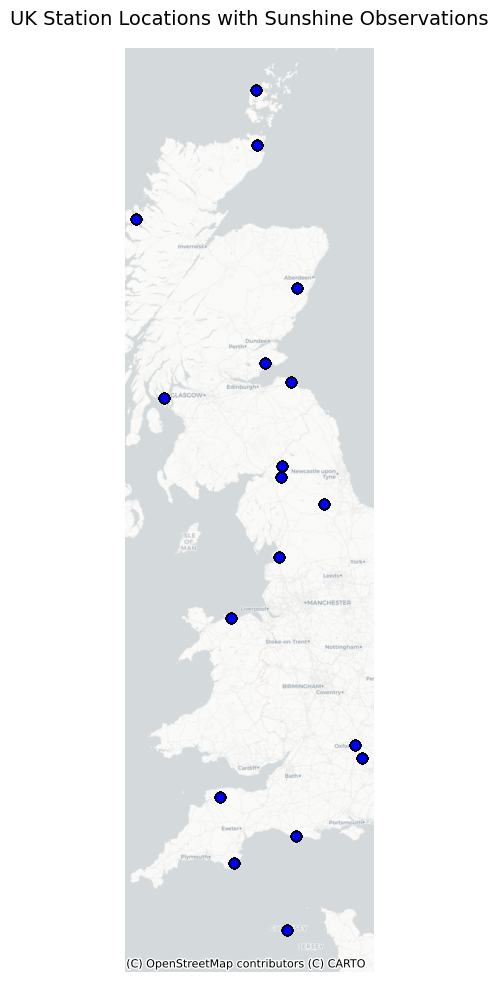

In [93]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# create GeoDataFrame from coordinates
geometry = [Point(xy) for xy in zip(sun_filtered['Longitude'], sun_filtered['Latitude'])]
gdf = gpd.GeoDataFrame(sun_filtered, geometry=geometry, crs="EPSG:4326")

# reproject to Web Mercator for compatibility with contextily
gdf_web = gdf.to_crs(epsg=3857)

# plot
fig, ax = plt.subplots(figsize=(10, 12))
gdf_web.plot(ax=ax, markersize=50, color='blue', edgecolor='black', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("UK Station Locations with Sunshine Observations", fontsize=14)
ax.set_axis_off()

plt.show()

### 1.4. UK mean wind data

With the HadUK-Grid rain and temperature data integrated, now we can move on to working with wind data.

#### 1.4.1 Loading in

Column names were not included in the raw wind file. The names for the file were found online at https://artefacts.ceda.ac.uk/badc_datadocs/ukmo-midas/WM_Table.html 

First, set the col names before loading in the wind data:

In [29]:
# define the header based on provided column names
column_names = [
    "OB_END_TIME", "ID_TYPE", "ID", "OB_HOUR_COUNT", "MET_DOMAIN_NAME",
    "VERSION_NUM", "SRC_ID", "REC_ST_IND", "MEAN_WIND_DIR", "MEAN_WIND_SPEED",
    "MAX_GUST_DIR", "MAX_GUST_SPEED", "MAX_GUST_CTIME", "MEAN_WIND_DIR_Q",
    "MEAN_WIND_SPEED_Q", "MAX_GUST_DIR_Q", "MAX_GUST_SPEED_Q", "MAX_GUST_CTIME_Q",
    "METO_STMP_TIME", "MIDAS_STMP_ETIME", "MEAN_WIND_DIR_J", "MEAN_WIND_SPEED_J",
    "MAX_GUST_DIR_J", "MAX_GUST_SPEED_J"
]

# read CSV and treat empty strings as NaN
df = pd.read_csv(
    "Data/midas_wind_202401-202412.txt",
    header=None,
    names=column_names,
    na_values=['', ' '],  # Treat empty strings and single spaces as NaN
    keep_default_na=True
)

# check result
display(df.head())
print(df.isna().sum())  # Check number of NaNs per column

,OB_END_TIME,ID_TYPE,ID,OB_HOUR_COUNT,MET_DOMAIN_NAME,VERSION_NUM,SRC_ID,REC_ST_IND,MEAN_WIND_DIR,MEAN_WIND_SPEED,...,MEAN_WIND_SPEED_Q,MAX_GUST_DIR_Q,MAX_GUST_SPEED_Q,MAX_GUST_CTIME_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,MEAN_WIND_DIR_J,MEAN_WIND_SPEED_J,MAX_GUST_DIR_J,MAX_GUST_SPEED_J
0,2024-01-01 00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,200.0,4.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
1,2024-01-01 00:00,CLBN,240301,1,AWSHRLY,1,18907,1011,240.0,15.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
2,2024-01-01 00:00,CLBN,247201,1,AWSHRLY,1,62283,1011,250.0,20.0,...,0.0,0.0,0.0,0.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
3,2024-01-01 00:00,CLBN,421002,1,AWSHRLY,1,61974,1011,240.0,13.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
4,2024-01-01 00:00,CLBN,455501,1,AWSHRLY,1,62047,1011,230.0,13.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN


OB_END_TIME                0
ID_TYPE                    0
ID                         0
OB_HOUR_COUNT              0
MET_DOMAIN_NAME            0
VERSION_NUM                0
SRC_ID                     0
REC_ST_IND                 0
MEAN_WIND_DIR          48472
MEAN_WIND_SPEED        45913
MAX_GUST_DIR           49228
MAX_GUST_SPEED          3048
MAX_GUST_CTIME         45471
MEAN_WIND_DIR_Q        48018
MEAN_WIND_SPEED_Q      45369
MAX_GUST_DIR_Q         48495
MAX_GUST_SPEED_Q        2500
MAX_GUST_CTIME_Q       44925
METO_STMP_TIME             0
MIDAS_STMP_ETIME           1
MEAN_WIND_DIR_J      1902520
MEAN_WIND_SPEED_J    1902520
MAX_GUST_DIR_J       1902520
MAX_GUST_SPEED_J     1902520
dtype: int64


#### 1.4.2. Wrangling

At this stage we begin making the data usable. 

We want to keep the best quality-checked data, and remove duplicate rows:

In [ ]:
# sort by VERSION_NUM descending to prioritize 1 over 0
df_sorted = df.sort_values(by='VERSION_NUM', ascending=False)

# drop duplicates keeping the first (VERSION_NUM==1 if available)
# version 1 is quality controlled, so we keep that if available
wind_deduped = df_sorted.drop_duplicates(subset=['ID', 'OB_END_TIME'], keep='first')

# reset index
wind_deduped.reset_index(drop=True, inplace=True)

# preview result
display(wind_deduped.head())

,OB_END_TIME,ID_TYPE,ID,OB_HOUR_COUNT,MET_DOMAIN_NAME,VERSION_NUM,SRC_ID,REC_ST_IND,MEAN_WIND_DIR,MEAN_WIND_SPEED,...,MEAN_WIND_SPEED_Q,MAX_GUST_DIR_Q,MAX_GUST_SPEED_Q,MAX_GUST_CTIME_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,MEAN_WIND_DIR_J,MEAN_WIND_SPEED_J,MAX_GUST_DIR_J,MAX_GUST_SPEED_J
0,2024-12-31 23:00,WMO,88897,1,SYNOP,1,1611,1011,NaN,NaN,...,NaN,NaN,1.0,NaN,2024-12-31 23:02,119.0,NaN,NaN,NaN,NaN
1,2024-01-01 00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,200.0,4.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
2,2024-01-01 00:00,CLBN,240301,1,AWSHRLY,1,18907,1011,240.0,15.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
3,2024-01-01 00:00,CLBN,247201,1,AWSHRLY,1,62283,1011,250.0,20.0,...,0.0,0.0,0.0,0.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
4,2024-01-01 00:00,CLBN,421002,1,AWSHRLY,1,61974,1011,240.0,13.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN


Take a look at the data to see how it's structured:

In [31]:
# filter for SRC_ID 62009 and sort by OB_END_TIME
obs_62009 = wind_deduped[wind_deduped['SRC_ID'] == 62009].copy()
obs_62009['OB_END_TIME'] = pd.to_datetime(obs_62009['OB_END_TIME'])
obs_62009 = obs_62009.sort_values('OB_END_TIME')
display(obs_62009)

,OB_END_TIME,ID_TYPE,ID,OB_HOUR_COUNT,MET_DOMAIN_NAME,VERSION_NUM,SRC_ID,REC_ST_IND,MEAN_WIND_DIR,MEAN_WIND_SPEED,...,MEAN_WIND_SPEED_Q,MAX_GUST_DIR_Q,MAX_GUST_SPEED_Q,MAX_GUST_CTIME_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,MEAN_WIND_DIR_J,MEAN_WIND_SPEED_J,MAX_GUST_DIR_J,MAX_GUST_SPEED_J
1,2024-01-01 00:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,200.0,4.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
202,2024-01-01 01:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,210.0,4.0,...,106.0,106.0,106.0,106.0,2024-01-01 01:03,0.0,NaN,NaN,NaN,NaN
395,2024-01-01 02:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,220.0,3.0,...,106.0,106.0,106.0,106.0,2024-01-01 02:03,0.0,NaN,NaN,NaN,NaN
588,2024-01-01 03:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,200.0,4.0,...,106.0,106.0,106.0,106.0,2024-01-01 03:03,0.0,NaN,NaN,NaN,NaN
780,2024-01-01 04:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,210.0,5.0,...,106.0,106.0,106.0,106.0,2024-01-01 04:03,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151230,2024-12-31 19:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,240.0,5.0,...,1.0,1.0,1.0,1.0,2024-12-31 19:02,0.0,NaN,NaN,NaN,NaN
116937,2024-12-31 20:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,210.0,12.0,...,1.0,1.0,1.0,1.0,2024-12-31 20:02,0.0,NaN,NaN,NaN,NaN
88613,2024-12-31 21:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,200.0,14.0,...,1.0,1.0,1.0,1.0,2024-12-31 21:02,0.0,NaN,NaN,NaN,NaN
58994,2024-12-31 22:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,250.0,11.0,...,1.0,1.0,1.0,1.0,2024-12-31 22:02,0.0,NaN,NaN,NaN,NaN


We have observations for each station throughout the day. We want to generate daily values, to match the HadUK data. 

We do this by taking the mean of observations between 6am and 10pm. These hours were chosen to reflect a range most relevant to retail activity. 

Calculate daily values:

In [32]:
wind_deduped = wind_deduped.copy()

# force datetime conversion and coerce errors
wind_deduped['OB_END_TIME'] = pd.to_datetime(wind_deduped['OB_END_TIME'], errors='coerce')

# drop rows where conversion failed
wind_deduped = wind_deduped.dropna(subset=['OB_END_TIME'])

# extract time and date
wind_deduped.loc[:, 'hour'] = wind_deduped['OB_END_TIME'].dt.hour
wind_deduped.loc[:, 'date'] = wind_deduped['OB_END_TIME'].dt.date

# filter rows between 6am (inclusive) and 10pm (exclusive)
daytime = wind_deduped[(wind_deduped['hour'] >= 6) & (wind_deduped['hour'] < 22)]

# Group by SRC_ID and date
grouped = daytime.groupby(['SRC_ID', 'date'])

# calculate mean of MEAN_WIND_SPEED and max of MAX_GUST_SPEED, skipping NaNs
daily_wind = (
    daytime
    .groupby(['SRC_ID', 'date'])
    .agg(
        mean_wind_speed_daytime=('MEAN_WIND_SPEED', 'mean'),
        max_gust_speed_daytime=('MAX_GUST_SPEED', 'max')
    )
    .reset_index()
)

Check the result:

In [33]:
display(daily_wind.head())

,SRC_ID,date,mean_wind_speed_daytime,max_gust_speed_daytime
0,3,2024-01-01,16.3750,35.0
1,3,2024-01-02,33.3750,63.0
2,3,2024-01-03,26.6250,49.0
3,3,2024-01-04,26.0000,45.0
4,3,2024-01-05,25.6875,44.0


In [ ]:
# check how many unique SRC_ID (wind stations) we have
print(len(daily_wind['SRC_ID'].unique()))

226


In [ ]:
# check how many unique dates we have
print(len(daily_wind['date'].unique()))

366


2024 was a leap year, so this actually makes sense!

This is where things get a bit trickier.

We want to end up with data from wind stations where all the days are matching. Certain stations have missing data on specific days due to quality control or station errors. 

If dates are not matching, this will mess up the modelling process later on due to inconsistencies in temporal coverage, leading to biased estimates and difficulties in attributing observed footfall variation to weather effects.

So, we have to create a subset of stations where the number of matching dates and number of stations are both maximised.

In [36]:
date_counts = daily_wind.groupby('SRC_ID')['date'].nunique()

To do this, we can plot the number of matching dates v. stations:

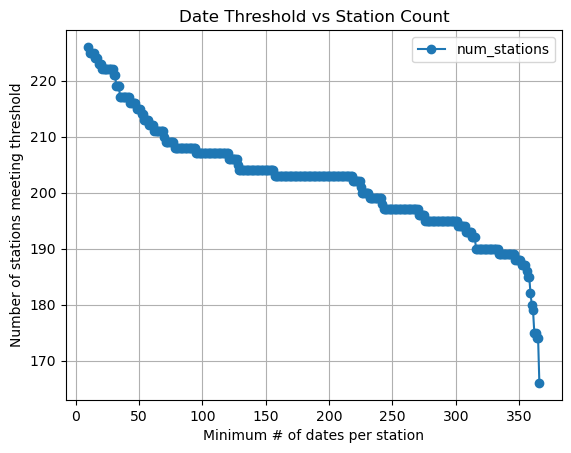

In [37]:
thresholds = range(10, date_counts.max() + 1)
results = [(t, (date_counts >= t).sum()) for t in thresholds]

# convert to DataFrame
threshold_df = pd.DataFrame(results, columns=['min_dates', 'num_stations'])

# plot the tradeoff
threshold_df.plot(x='min_dates', y='num_stations', title='Date Threshold vs Station Count', marker='o')
plt.xlabel("Minimum # of dates per station")
plt.ylabel("Number of stations meeting threshold")
plt.grid(True)
plt.show()

330 days seems to be the best point before there is a steep drop off in data availability. 

We select stations that have at least 330 days coverage:

In [38]:
# count how many times each ID appears
id_counts = daily_wind['SRC_ID'].value_counts()

# get IDs with at least 330 occurrences
valid_ids = id_counts[id_counts >= 330].index

# filter the DataFrame
wind_filtered = daily_wind[daily_wind['SRC_ID'].isin(valid_ids)]

# reset index
wind_filtered.reset_index(drop=True, inplace=True)

# preview result
display(wind_filtered.head())

,SRC_ID,date,mean_wind_speed_daytime,max_gust_speed_daytime
0,3,2024-01-01,16.3750,35.0
1,3,2024-01-02,33.3750,63.0
2,3,2024-01-03,26.6250,49.0
3,3,2024-01-04,26.0000,45.0
4,3,2024-01-05,25.6875,44.0


And match stations together:

In [39]:
wind_filtered = wind_filtered.copy()

# convert date to datetime
wind_filtered['date'] = pd.to_datetime(wind_filtered['date'], errors='coerce')

# convert datetime to just the date part for grouping
wind_filtered['date'] = wind_filtered['date'].dt.date

# count how many unique SRC_IDs you have
num_stations = wind_filtered['SRC_ID'].nunique()

# count how many unique SRC_IDs reported data on each date
station_counts_per_day = wind_filtered.groupby('date')['SRC_ID'].nunique()

# filter to dates where all SRC_IDs are present
full_coverage_dates = station_counts_per_day[station_counts_per_day == num_stations].index

# get only rows from those dates
wind_full_coverage = wind_filtered[wind_filtered['date'].isin(full_coverage_dates)]

display(wind_full_coverage.head())

,SRC_ID,date,mean_wind_speed_daytime,max_gust_speed_daytime
14,3,2024-01-15,21.666667,46.0
15,3,2024-01-16,13.642857,33.0
16,3,2024-01-17,15.812500,36.0
17,3,2024-01-18,19.000000,47.0
18,3,2024-01-19,12.875000,36.0


In [40]:
# Check for NaNs in mean_wind_speed_daytime and max_gust_speed_daytime
mean_wind_nans = wind_full_coverage['mean_wind_speed_daytime'].isna().sum()
max_gust_nans = wind_full_coverage['max_gust_speed_daytime'].isna().sum()

print(f"Number of NaNs in mean_wind_speed_daytime: {mean_wind_nans}")
print(f"Number of NaNs in max_gust_speed_daytime: {max_gust_nans}")

Number of NaNs in mean_wind_speed_daytime: 95
Number of NaNs in max_gust_speed_daytime: 48


In [41]:
print(wind_full_coverage['SRC_ID'].unique())
len(wind_full_coverage['SRC_ID'].unique())

[    3     9    12    23    32    44    48    52    54    67    79   103
   105   113   117   132   137   145   150   161   177   212   235   268
   315   358   370   373   384   386   393   395   405   409   421   440
   456   461   498   513   534   554   556   583   595   605   613   643
   657   669   671   692   708   709   719   723   726   743   744   775
   779   795   811   842   847   862   876   888   889   908   918   982
   987  1007  1023  1033  1039  1046  1055  1060  1074  1076  1078  1083
  1085  1090  1125  1137  1144  1145  1161  1171  1180  1190  1198  1209
  1215  1226  1285  1302  1319  1336  1346  1352  1367  1383  1386  1393
  1395  1415  1435  1448  1450  1467  1488  1504  1529  1530  1534  1543
  1575  1585  1588  1605  1609  6182  6313  9861 16589 16596 16611 16725
 17224 17309 17314 17344 18903 18907 18915 18974 19187 19188 19206 19260
 23417 24102 24125 24996 25069 25727 30270 30523 30620 30690 56486 56810
 56958 56962 56963 57063 57192 57193 57199 57231 57

190

We can write the final stations and wind observations data to a new .csv:

In [42]:
# extract unique SRC_IDs from wind_full_coverage and write to CSV
unique_src_ids = wind_full_coverage['SRC_ID'].unique()
pd.DataFrame({'SRC_ID': unique_src_ids}).to_csv('unique_wind_station_ids.csv', index=False)

In order to interpolate this data to retail centres, we need geographic info.

The lat and long of wind stations was sourced directly via email from the Met Office. They were kind enough to provide the coords for the stations I had selected.

In [ ]:
# load the lat/long data for the selected wind stations
wind_latlong = pd.read_csv("Data/unique_wind_station_ids_LATLONG_nonstandard.csv")

We can use an inner merge based on station ID to add in the coordinate data:

In [44]:
wind_final = wind_full_coverage.merge(wind_latlong, on='SRC_ID', how='inner')
display(wind_final.head())
print(len(wind_final['SRC_ID'].unique()))

,SRC_ID,date,mean_wind_speed_daytime,max_gust_speed_daytime,Name,Lat,Long,Non-standard
0,3,2024-01-15,21.666667,46.0,FAIR ISLE,59.52607,-1.62959,NaN
1,3,2024-01-16,13.642857,33.0,FAIR ISLE,59.52607,-1.62959,NaN
2,3,2024-01-17,15.812500,36.0,FAIR ISLE,59.52607,-1.62959,NaN
3,3,2024-01-18,19.000000,47.0,FAIR ISLE,59.52607,-1.62959,NaN
4,3,2024-01-19,12.875000,36.0,FAIR ISLE,59.52607,-1.62959,NaN


190


We also want to get rid of non-standard stations (the cord data from Met Office also highlighted certain stations that are not reliable and should be removed):

In [ ]:
# remove non-standard stations- nan means that the station is standard
wind_final = wind_final[pd.isna(wind_final['Non-standard'])]

In [ ]:
# let's check the result
display(wind_final.head())
print(len(wind_final['SRC_ID'].unique()))
print(len(wind_final['date'].unique()))

,SRC_ID,date,mean_wind_speed_daytime,max_gust_speed_daytime,Name,Lat,Long,Non-standard
0,3,2024-01-15,21.666667,46.0,FAIR ISLE,59.52607,-1.62959,NaN
1,3,2024-01-16,13.642857,33.0,FAIR ISLE,59.52607,-1.62959,NaN
2,3,2024-01-17,15.812500,36.0,FAIR ISLE,59.52607,-1.62959,NaN
3,3,2024-01-18,19.000000,47.0,FAIR ISLE,59.52607,-1.62959,NaN
4,3,2024-01-19,12.875000,36.0,FAIR ISLE,59.52607,-1.62959,NaN


158
255


Finally, we have our final wind dataframe. 

In [47]:
wind_final = wind_final.drop(columns=['Non-standard'])

#### 1.4.3. Interpolation Prep

For interpolation to work well, we want to make sure stations are dispersed across the country.

Let's map the station sites to make sure spatial coverage is fairly even:

In [48]:
print(wind_final.columns)

Index(['SRC_ID', 'date', 'mean_wind_speed_daytime', 'max_gust_speed_daytime',
       'Name', 'Lat ', 'Long'],
      dtype='object')


In [49]:
wind_final = wind_final.rename(columns={'Lat ': 'lat', 'Long': 'lon'})

In [50]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(wind_final['lon'], wind_final['lat'])]
wind_gdf = gpd.GeoDataFrame(wind_final, geometry=geometry, crs="EPSG:4326")

In [51]:
wind_gdf.to_file("wind_gdf.gpkg", layer="wind_gdf", driver="GPKG")

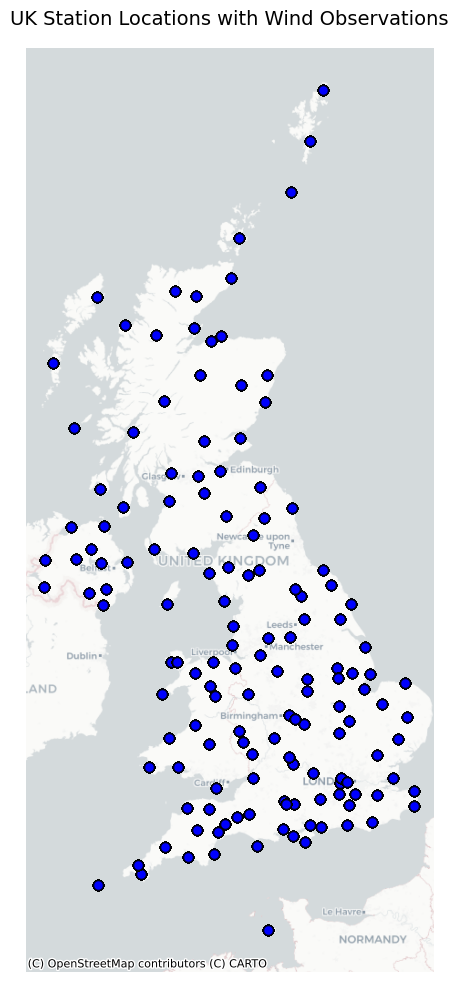

In [ ]:
import contextily as ctx

# reproject to Web Mercator for compatibility with contextily
gdf_web = wind_gdf.to_crs(epsg=3857)

# plot
fig, ax = plt.subplots(figsize=(10, 12))
gdf_web.plot(ax=ax, markersize=50, color='blue', edgecolor='black', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("Met Office Station Locations with Wind Observations", fontsize=14)
ax.set_axis_off()

plt.show()

We have lots of stations scattered across the UK, so this looks good. 

### 1.5. Joining wind to retail via linear interpolation

Interpolation time! 

Instead of creating a full continuous surface, we estimate wind values directly at each retail centre’s centroid. Observed wind speeds from weather stations are used to calculate values at these target locations based on their proximity to known points.

In practice, linear interpolation is applied first to provide smooth estimates. 
Where a centroid lies outside the area covered by stations, nearest-neighbour interpolation is used as a fallback. This ensures that every retail location receives an estimated daily wind value, even when no station is located nearby.

Once again, we do this for each date in the data:

In [ ]:
# ensure date is datetime format
wind_gdf['date'] = pd.to_datetime(wind_gdf['date'], errors='coerce')

Now we can execute the interpolation:

In [ ]:
from scipy.interpolate import griddata
import numpy as np

# create result columns 
retail_areas['mean_wind'] = np.nan
retail_areas['max_gust'] = np.nan

# loop through each date
for date in retail_areas['date'].unique():
    # get weather station data for this date
    weather_subset = wind_gdf[
        wind_gdf['date'] == date
    ].dropna(subset=['lon', 'lat', 'mean_wind_speed_daytime', 'max_gust_speed_daytime'])

    if weather_subset.empty:
        continue

    # get centroids for retail areas on this date
    mask = retail_areas['date'] == date
    centroid_points = retail_areas.loc[mask, ['centroid_x', 'centroid_y']].values

    # weather station data
    station_coords = weather_subset[['lon', 'lat']].values
    mean_vals = weather_subset['mean_wind_speed_daytime'].values
    gust_vals = weather_subset['max_gust_speed_daytime'].values

    # interpolate directly to centroid coordinates
    mean_interpolated = griddata(station_coords, mean_vals, centroid_points, method='linear')
    gust_interpolated = griddata(station_coords, gust_vals, centroid_points, method='linear')

    # fill NaNs with nearest neighbor interpolation
    if np.any(np.isnan(mean_interpolated)):
        mean_interpolated[np.isnan(mean_interpolated)] = griddata(
            station_coords, mean_vals, centroid_points[np.isnan(mean_interpolated)], method='nearest'
        )
    if np.any(np.isnan(gust_interpolated)):
        gust_interpolated[np.isnan(gust_interpolated)] = griddata(
            station_coords, gust_vals, centroid_points[np.isnan(gust_interpolated)], method='nearest'
        )

    # store results
    retail_areas.loc[mask, 'mean_wind'] = mean_interpolated
    retail_areas.loc[mask, 'max_gust'] = gust_interpolated

And check the result:

In [124]:
display(retail_areas.head())

,date,id,events,weekend,season,holiday,Local Footprint Name,Region,Base Score,Retail Footprint Score,...,coastal,geometry,centroid,rainfall,tasmax,tasmin,centroid_x,centroid_y,mean_wind,max_gust
0,2024-10-11,17519.0,787.0,False,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),0.020508,13.706055,1.581055,0.277208,51.484639,3.113659,11.787185
1,2024-12-14,17519.0,2128.0,True,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),0.005859,9.276367,3.638672,0.277208,51.484639,NaN,NaN
2,2024-12-07,17519.0,1621.0,True,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),5.839844,8.677734,6.519531,0.277208,51.484639,NaN,NaN
3,2024-12-09,17519.0,1471.0,False,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),1.134766,8.494141,6.331055,0.277208,51.484639,NaN,NaN
4,2024-12-08,17519.0,1270.0,True,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),1.407227,8.735352,6.326172,0.277208,51.484639,NaN,NaN


In [125]:
# print rows in retail_areas where mean_wind is not NaN
display(retail_areas[~retail_areas['mean_wind'].isna()])

,date,id,events,weekend,season,holiday,Local Footprint Name,Region,Base Score,Retail Footprint Score,...,coastal,geometry,centroid,rainfall,tasmax,tasmin,centroid_x,centroid_y,mean_wind,max_gust
0,2024-10-11,17519.0,787.0,False,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),0.020508,13.706055,1.581055,0.277208,51.484639,3.113659,11.787185
8,2024-10-10,17519.0,1149.0,False,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),0.073242,12.133789,9.456055,0.277208,51.484639,6.268236,16.051210
9,2024-10-09,17519.0,953.0,False,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),1.086914,16.552734,12.773438,0.277208,51.484639,5.888794,18.588509
12,2024-09-27,17519.0,1549.0,False,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),1.431641,14.000000,9.723633,0.277208,51.484639,9.651992,26.459619
13,2024-09-28,17519.0,2242.0,True,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,inland,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),0.012695,15.671875,3.596680,0.277208,51.484639,4.693159,14.897580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437675,2024-01-18,4860.0,46.0,False,Winter,False,Bury - Peel Way,North West,704.0,678.0,...,inland,"MULTIPOLYGON (((-2.29326 53.5955, -2.29316 53....",POINT (-2.29319 53.59553),0.215820,3.023438,-7.592773,-2.293194,53.595528,1.998215,12.022784
437676,2024-01-17,4860.0,32.0,False,Winter,False,Bury - Peel Way,North West,704.0,678.0,...,inland,"MULTIPOLYGON (((-2.29326 53.5955, -2.29316 53....",POINT (-2.29319 53.59553),0.114258,1.634766,-3.333008,-2.293194,53.595528,1.842319,8.104190
437677,2024-01-16,4860.0,18.0,False,Winter,False,Bury - Peel Way,North West,704.0,678.0,...,inland,"MULTIPOLYGON (((-2.29326 53.5955, -2.29316 53....",POINT (-2.29319 53.59553),4.345703,2.497070,-3.930664,-2.293194,53.595528,4.954689,16.662093
437678,2024-01-15,4860.0,50.0,False,Winter,False,Bury - Peel Way,North West,704.0,678.0,...,inland,"MULTIPOLYGON (((-2.29326 53.5955, -2.29316 53....",POINT (-2.29319 53.59553),0.001953,1.710938,-4.237305,-2.293194,53.595528,3.850401,16.288509


### 1.6. Final CSV

We've now successully brought together all the footfall, retail, and weather data. 

We can write this out to our final retail areas .csv which will be used at the modelling stage:

In [126]:
# Write the final retail_areas DataFrame to CSV
retail_areas.to_csv("retail_areas_final.csv", index=False)

In [127]:
print(retail_areas.columns)

Index(['date', 'id', 'events', 'weekend', 'season', 'holiday',
       'Local Footprint Name', 'Region', 'Base Score',
       'Retail Footprint Score', 'Residential Population (Weighted Catchment)',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       'Tourism Score', 'Local_Footprint_Centre_ID',
       'Local_Footprint_Centre_Name', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
       '

In [128]:
print(retail_areas.dtypes)

date                                                      datetime64[ns]
id                                                               float64
events                                                           float64
weekend                                                           object
season                                                            object
holiday                                                           object
Local Footprint Name                                              object
Region                                                            object
Base Score                                                       float64
Retail Footprint Score                                           float64
Residential Population (Weighted Catchment)                      float64
Spend Per Head (Residential)                                     float64
Sparsity                                                          object
Longitude                                          

In [129]:
display(retail_areas.isna().sum())

date                                                           0
id                                                             0
events                                                         0
weekend                                                        0
season                                                         0
holiday                                                        0
Local Footprint Name                                           0
Region                                                         0
Base Score                                                     0
Retail Footprint Score                                         0
Residential Population (Weighted Catchment)                    0
Spend Per Head (Residential)                                   0
Sparsity                                                       0
Longitude                                                      0
Latitude                                                       0
Tourism Score            